In [1]:
# from offical Grounded SAM repo https://github.com/IDEA-Research/Grounded-Segment-Anything
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [2]:
# Installing Grounding DINO
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!git checkout -q 57535c5a79791cb76e36fdb64975271354f10251
!pip install -q -e .

/content
fatal: destination path 'GroundingDINO' already exists and is not an empty directory.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done


In [3]:
# Installing Segment Anything (SAM)
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-jmwh5rct
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-jmwh5rct
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 567662b0fd33ca4b022d94d3b8de896628cd32dd
  Preparing metadata (setup.py) ... done


In [4]:
# Installing supervision latest version
!pip uninstall -y supervision
!pip install -q supervision==0.6.0

import supervision as sv
print(sv.__version__)

Found existing installation: supervision 0.4.0
Uninstalling supervision-0.4.0:
  Successfully uninstalled supervision-0.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
groundingdino 0.1.0 requires supervision==0.4.0, but you have supervision 0.6.0 which is incompatible.
0.6.0


In [5]:
# Grounding DINO requires configuration file and weights to run.
import os

GROUNDING_DINO_CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(GROUNDING_DINO_CONFIG_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CONFIG_PATH))

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [6]:
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content
/content/weights


In [7]:
import os

GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
print(GROUNDING_DINO_CHECKPOINT_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CHECKPOINT_PATH))

/content/weights/groundingdino_swint_ogc.pth ; exist: True


In [8]:
# SAM weights
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [9]:
import os

SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(SAM_CHECKPOINT_PATH, "; exist:", os.path.isfile(SAM_CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [10]:
# Load Models
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
# Load Grounding Dino 
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import Model

grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

/content/GroundingDINO


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
# Load Segment Anything(SAM)
SAM_ENCODER_VERSION = "vit_h"

In [13]:
from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)

In [14]:
# Prediction with Grounding DINO
SOURCE_IMAGE_PATH = f"{HOME}/testingarea.PNG"
CLASSES = ['person', 'boat','ocean','ship','sky']
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

In [15]:
from typing import List

def enhance_class_name(class_names: List[str]) -> List[str]:
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


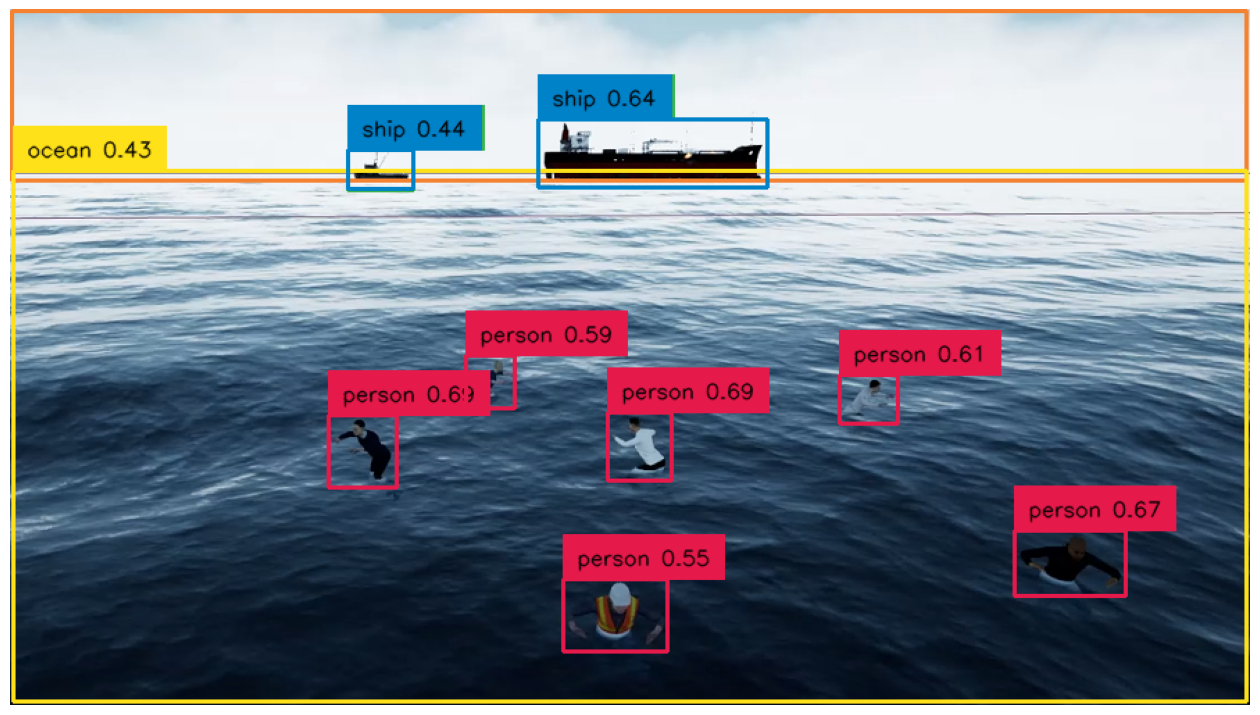

In [16]:
import cv2
import supervision as sv

# load image
image = cv2.imread(SOURCE_IMAGE_PATH)

# detect objects
detections = grounding_dino_model.predict_with_classes(
    image=image,
    classes=enhance_class_name(class_names=CLASSES),
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}" 
    for _, _, confidence, class_id, _ 
    in detections]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

In [17]:
# Segmentation with SAM
import numpy as np
from segment_anything import SamPredictor


def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

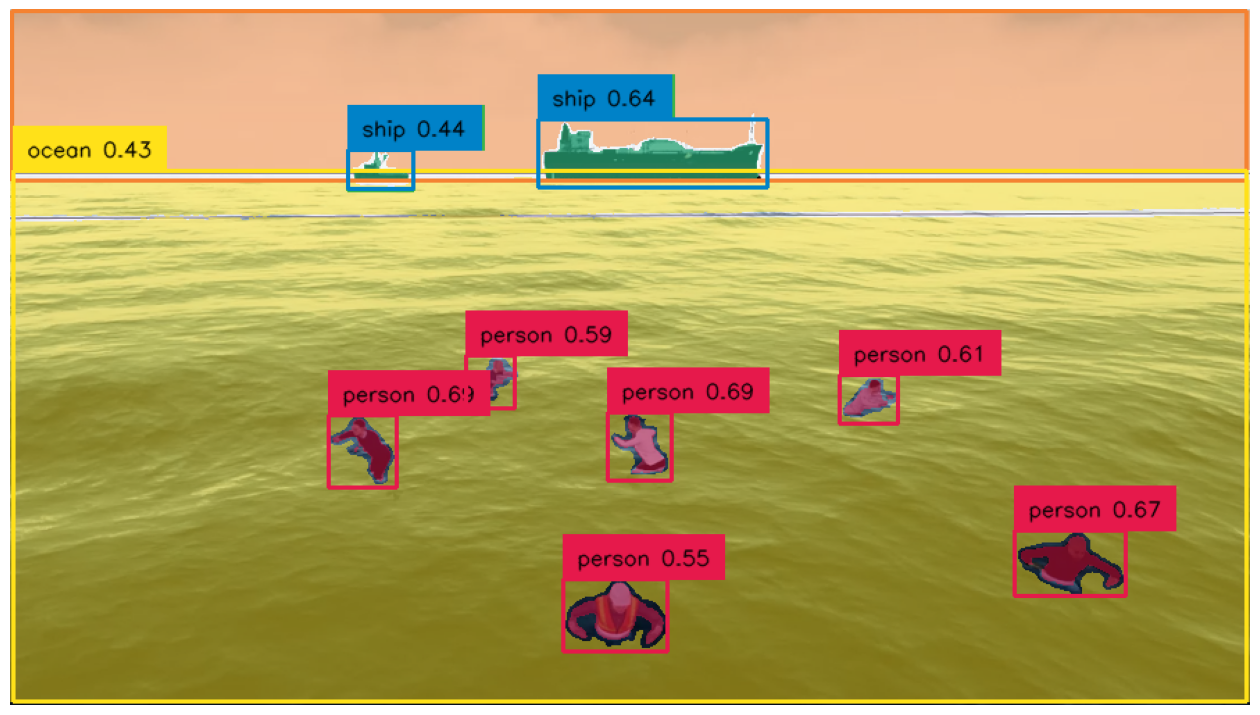

In [18]:
import cv2

# convert detections to masks
detections.mask = segment(
    sam_predictor=sam_predictor,
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    xyxy=detections.xyxy
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}" 
    for _, _, confidence, class_id, _ 
    in detections]
annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_image, (16, 16))